In [1]:
import sys
sys.path.insert(0,'C:\\code\\python_for_the_financial_economist\\')

"""
Magic commands
"""

%load_ext autoreload
%autoreload 2

"""
Load relevant packages
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib import animation, cm
import seaborn as sns
import datetime
from scipy import stats
from scipy import optimize

from pandas_datareader.data import DataReader
from pandas_datareader.famafrench import FamaFrenchReader, get_available_datasets

from statsmodels.tools.numdiff import approx_fprime, approx_hess

from typing import Union, List

"""
Own packages
"""
from codelib.dal.fred_yield_data import get_nominal_yield_data

from codelib.visualization.base import correlation_plot, fan_chart
from codelib.visualization.layout import DefaultStyle, default_colors
DefaultStyle();

from codelib.fixed_income.curves.vasicek_curve import VasicekCurve

# Exercises - Week 7

In this week we will look at 

* The Vasicek model
* Dynamic Nelson-Siegel model
* Principle components


## Problem 1: The Vasicek model

__Note:__ The notation follows [Claus Munk (2013), "Fixed income modelling"](https://www.amazon.co.uk/Fixed-Income-Modelling-Claus-Munk/dp/0198716443)

The [Vasicek model](https://en.wikipedia.org/wiki/Vasicek_model) of [Vasicek (1977)](https://www.sciencedirect.com/science/article/abs/pii/0304405X77900162?via%3Dihub) specifies the full yield curve in terms of a single state variable namely the short rate. It is assumed that the short rate, $r_t$ follows an Ornstein-Uhlenbeck process

$$
dr_t = \kappa [\theta - r_t] dt + \beta z_t^\mathbb{P}
$$

where $^\mathbb{P}$ indicates that the dynamics are specified under the real-world probability measure. $\kappa, \theta$ and $\beta$ are positive constants. We can think of $\theta$ as the long-run level for the short rate. The short rate will be mean-reverting to $\theta$ such that if $r_t > \theta$ the drift term will be negative. $\kappa$ is the speed of adjustment. 

__Question 1__

It is possible to show that the future short rate is normally distributed with expectation and variance given by

$$
\text{E}_t [r_s] = \theta + (r_t - \theta) e^{- \kappa (s-t)}
$$

and 

$$
\text{Var}_t [r_s] = \frac{\beta^2}{2 \kappa} \left(1 - e^{- 2 \kappa (s-t)} \right)
$$

We note that when $s \to \infty$ then $\text{E}_t [r_s]  \to \theta$ and $\text{Var}_t [r_s] \to \frac{\beta^2}{2 \kappa}$. 

This information is usefull when simulating the short rate into the future. Define a function that can simulate future paths of the short rate. The function should take as input: `initial_short_rate`, `kappa`, `theta`, `beta`, `horizon` (in years), `dt` (step size in years, eg. 1/12 for monthly) and `num_sim` (number of simulations). 

Assume a initial short rate of $r_t=0.01$ and $\kappa=0.36$, $\theta =0.08$ and $\beta = 0.0265$. Simulate 10,000 paths of the short rate for the next 20 years with monthly time steps. 

Plot a fan chart with the 2.5, 5, 10, 50, 90, 95, and 97.5 percentile (use e.g `codelib.visualization.base.fan_chart`).

__Question 2__

For risk-neutral pricing, we need the dynamics under $\mathbb{Q}$ (the risk-neutral probability measure). Under the risk-neutral probability measure we have

$$
\begin{align}
dr_t &= \kappa [\theta - r_t] dt + \beta \left(z_t^\mathbb{Q} - \lambda dt \right) \\
    &= \kappa [\hat{\theta} - r_t] dt + \beta z_t^\mathbb{Q}
\end{align}
$$

where $\hat{\theta} = \theta - \frac{\lambda \beta}{\kappa}$. We see that the parameterization is identical under the risk-neutral probability measure - then only difference is in the magnitude of $\theta$. 

Plot the future paths of the short rate under the risk neutral measure. Assume $\lambda=-0.15$. 

__Question 3__

The Vasicek model is a so-called affine term structure model which implies that the price of a zero-coupon bond can be written as 

$$
B_t^T = e^{-a(T-t) - b(T-t) r_t} 
$$

It is possible to show that for the Vasicek model (let $\tau = T -t$)

$$
\begin{align}
a(\tau) &= y_\infty [\tau - b(\tau)] + \frac{\beta^2}{4 \kappa} b(\tau)^2\\
b(\tau) &= \frac{1}{\kappa} \left(1 - e^{-\kappa \tau} \right)
\end{align}
$$

with 

$$
y_\infty = \hat{\theta} - \frac{\beta^2}{2 \kappa^2} = \theta - \frac{\lambda \beta}{\kappa}- \frac{\beta^2}{2 \kappa^2}
$$

Define a function that returns the price of a zero coupon bond.

__Question 4__

Plot the 5-year zero coupon bond price for $\kappa \in [0.01, 3.0]$. Assume that $\theta = 0.05, \beta  = 0.03$ and $\lambda = -0.15$. Consider four different values of the initial short rate $r_t \in \{0.02, 0.04, 0.06, 0.08\}$

__Question 5__

Plot the 5-year zero coupon bond price for $\theta \in [0.0, 0.2]$. Assume that $\kappa = 0.3, \beta  = 0.03$ and $\lambda = -0.15$. Consider four different values of the initial short rate $r_t \in \{0.02, 0.04, 0.06, 0.08\}$

__Question 6__

Plot 1-year, 5-year and 10-year zero coupon bond price for $\beta \in [0.01, 0.2]$. Assume that $\kappa = 0.3, \theta  = 0.05$ and $\lambda = -0.15$. Assume $r_t =0.03$.

__Question 7__

Plot 1-year, 5-year and 10-year zero coupon bond price for $\lambda \in [-0.5, 0.5]$. Assume that $\kappa = 0.3, \theta  = 0.05$ and $\lambda = -0.15$. Assume $r_t =0.03$.

__Question 8__

It follows directly from 


$$
B_t^T = e^{-a(T-t) - b(T-t) r_t} 
$$

that the zero-coupon yield at time $t$ for maturity $T$ is given by 

$$
y_t^T = \frac{a(T-t)}{T-t}  + \frac{b(T-t)}{T-t}r_t = y_\infty + \frac{b(T-t)}{T-t} \left(\frac{\beta^2}{4 \kappa} b(T-t) + r - y_\infty \right)
$$


Define a `VasicekCurve` that inherit from `IRateCurve`  (see `codelib.fixed_income.curves`). Plot the yield curve for  $\kappa = 0.3, \theta  = 0.05, \beta=0.03$ and $\lambda = -0.15$. Assume $r_t =0.03$.


### Solution 

__Question 1__


In [2]:
def simulate_vasicek(initial_short_rate: float, kappa: float, theta: float, beta: float, horizon: float, 
                     dt: float=1.0/12, num_sim: int=10000):
    """
    simulates short rate processes in a vasicek setting until a given horizon 
    
    Parameters
    ----------
    
    initial_short_rate:
        initial short rate
    kappa: 
        speed of mean reversion.
    theta: 
        long term mean of the short rate.
    dt:
        increments in time
    horizon:
        time until maturity/expiry (horizon).
    num_sim:
        number of simulations.
    """
    std_rates = np.sqrt(beta**2 / (2 * kappa) * (1 - np.exp(-2 * kappa * dt)))
    
    num_periods = int(horizon / dt)
    short_rates = np.empty((num_sim, num_periods + 1))
    short_rates[:, 0] = initial_short_rate
    
    error_terms = np.random.normal(scale=std_rates, size=(num_sim, num_periods))
    
    for i in range(1, num_periods + 1): 
        
        short_rates[:, i] = theta + (short_rates[:, i - 1] - theta) * np.exp(-kappa * dt) + error_terms[:, i - 1]

    return short_rates

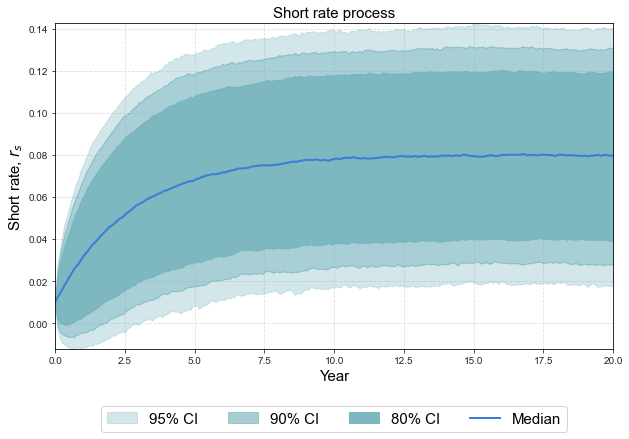

In [3]:
short_rates = simulate_vasicek(0.01, kappa=0.36, theta=0.08, beta=0.0265, horizon=20, dt=1.0/12.0, num_sim=10000)
time_points = np.arange(0, 20.01, 1.0/12.0)

# calculate percentiles
percentiles = np.percentile(short_rates, [2.5, 5, 10, 50, 90, 95, 97.5], axis=0)

"""
Plot fan chart
"""

fig, ax = plt.subplots(figsize=(10, 6))

fan_chart(time_points,
          percentiles,
          color=default_colors['cyan'],
          color_median=default_colors['dark_blue'],
          labels=['95% CI', '90% CI', '80% CI', 'Median'],
          ax=ax)

ax.set_xlabel("Year", size=15)
ax.set_ylabel("Short rate, $r_s$", size=15)
ax.set_title("Short rate process", size=15)

ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=5, fontsize=15);

__Question 2__

We see that the $\hat{\theta} > \theta$ implying that the probability under $\mathbb{Q}$ is shifted upwards. Note that this is intuitive if there should be a term premium for holding longer maturity bonds. 

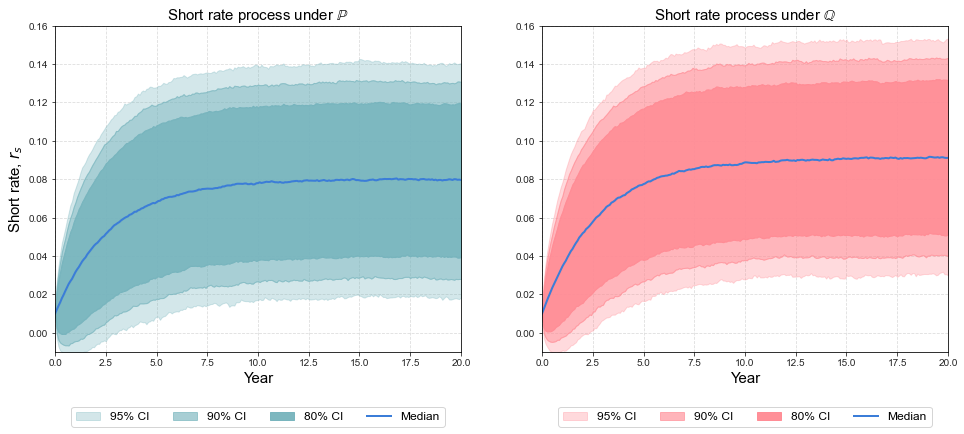

In [4]:
kappa = 0.36
beta = 0.0265
risk_premium = -0.15
theta = 0.08 - risk_premium * beta / kappa


short_rates_q = simulate_vasicek(0.01, kappa=kappa, theta=theta, beta=beta, horizon=20, dt=1.0/12.0, num_sim=10000)
time_points = np.arange(0, 20.01, 1.0/12.0)

# calculate percentiles
percentiles_q = np.percentile(short_rates_q, [2.5, 5, 10, 50, 90, 95, 97.5], axis=0)

"""
Plot fan chart
"""

fig, ax = plt.subplots(1, 2, figsize=(16, 6))

fan_chart(time_points,
          percentiles,
          color=default_colors['cyan'],
          color_median=default_colors['dark_blue'],
          labels=['95% CI', '90% CI', '80% CI', 'Median'],
          ax=ax[0])

ax[0].set_xlabel("Year", size=15)
ax[0].set_ylabel("Short rate, $r_s$", size=15)
ax[0].set_ylim([-0.01, 0.16])
ax[0].set_title("Short rate process under $\\mathbb{P}$", size=15)

ax[0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=5, fontsize=12);

fan_chart(time_points,
          percentiles_q,
          color=default_colors['red'],
          color_median=default_colors['dark_blue'],
          labels=['95% CI', '90% CI', '80% CI', 'Median'],
          ax=ax[1])

ax[1].set_xlabel("Year", size=15)
ax[1].set_ylim([-0.01, 0.16])
ax[1].set_title("Short rate process under $\\mathbb{Q}$", size=15)

ax[1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=5, fontsize=12);

__Question 3__

In [5]:
def calculate_zero_coupon_price(time_to_maturity: Union[float, np.ndarray],
                                initial_short_rate: float,
                                kappa: float,
                                theta: float,
                                beta: float,
                                risk_premium: float):
    
    y_infty = theta - risk_premium * beta / kappa - beta**2 / (2 * kappa**2)
    
    b = 1 / kappa * (1 - np.exp(-kappa * time_to_maturity))
    a = y_infty * (time_to_maturity  - b) + beta**2 / (4 * kappa) * b**2
    
    return np.exp(- a - b * initial_short_rate)

__Question 4__

$\kappa$ governs the speed of mean-reversion. When the speed of mean-reversion is high, then the price of the zero-coupon bond is less dependent on the initial level of the short rate. 

The price of a zero-coupon bond can be written as 

$$
E_{r,t}^\mathbb{Q} \left[ \exp \left(-\intop_t^T r_u du \right) \right]
$$

If the current short rate is lower than the long-term level, a high $\kappa$ will imply that $\intop_t^T r_u du$ is expected to be larger than than for low values of $\kappa$. This is why the zero-coupon price is descreasing in $\kappa$. 

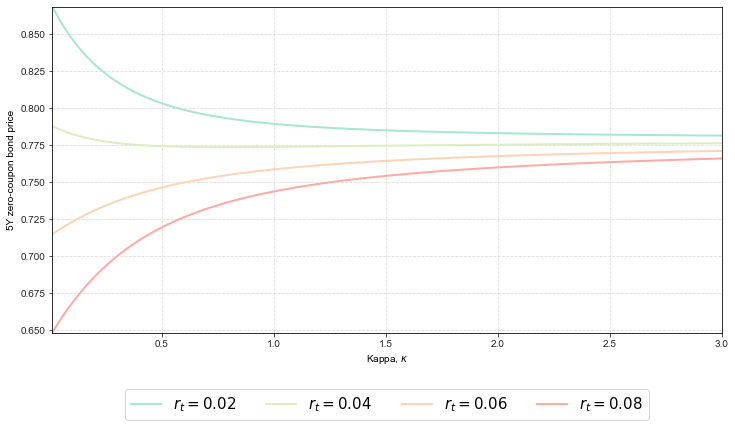

In [6]:
kappa_values = np.linspace(0.01, 3.0, 100)
theta = 0.05
beta = 0.03
risk_premium = -0.15

init_rates = [0.02, 0.04, 0.06, 0.08]

fig, ax = plt.subplots(figsize=(12, 6))

for r in init_rates: 
    
    bond_prices = [calculate_zero_coupon_price(5.0, r, k, theta, beta, risk_premium) for k in kappa_values]
    
    ax.plot(kappa_values, bond_prices, label="$r_t = {}$".format(r))

ax.set_ylabel("5Y zero-coupon bond price")
ax.set_xlabel("Kappa, $\kappa$")
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4, fontsize=15);

__Question 5__

The zero-coupon bond price is decreasing in $\theta$. $\intop_t^T r_u du$ is expected to increase when $\theta$ increases why the value of the zero-coupon decreases. 

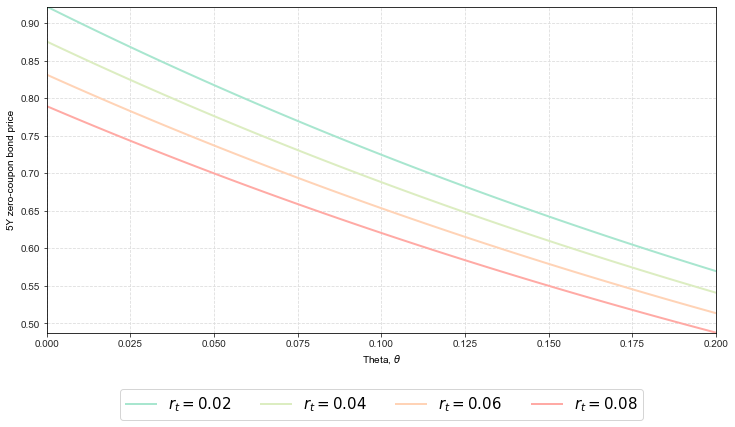

In [7]:
theta_values = np.linspace(0.0, 0.2, 100)
kappa = 0.3
beta = 0.03
risk_premium = -0.15

init_rates = [0.02, 0.04, 0.06, 0.08]

fig, ax = plt.subplots(figsize=(12, 6))

for r in init_rates: 
    
    bond_prices = [calculate_zero_coupon_price(5.0, r, kappa, t, beta, risk_premium) for t in theta_values]
    
    ax.plot(theta_values, bond_prices, label="$r_t = {}$".format(r))

ax.set_ylabel("5Y zero-coupon bond price")
ax.set_xlabel("Theta, $\\theta$")
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4, fontsize=15);

__Question 6__

The price is not a monotonic function of the interest rate volatility $\beta$. Long term bonds are more sensitive to $\beta$ than short bonds. 

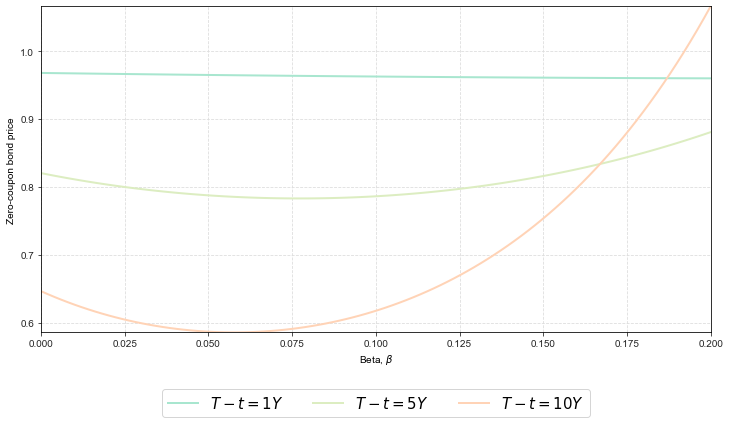

In [8]:
beta_values = np.linspace(0.0, 0.2, 100)
kappa = 0.3
beta = 0.03
theta = 0.05
r = 0.03
risk_premium = -0.15

init_rates = [0.02, 0.04, 0.06, 0.08]

fig, ax = plt.subplots(figsize=(12, 6))

years = [1, 5, 10]
for y in years: 
    
    bond_prices = [calculate_zero_coupon_price(y, r, kappa, theta, b, risk_premium) for b in beta_values]
    
    ax.plot(beta_values, bond_prices, label="$T-t = {}Y$".format(y))

ax.set_ylabel("Zero-coupon bond price")
ax.set_xlabel("Beta, $\\beta$")
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4, fontsize=15);

__Question 7__

It is possible to write the dynamics of a zero-coupon bond as (when the short rate follows a Vasicek model)

$$
dB_t^T = B_t^T \left[\left(r_t - \lambda b(T-t) \beta \right)dt + b(T-t) \beta dz_t \right]
$$

The more negative $\lambda$ is, the higher is the excess expected return on the bond. Thus, the current price must be lower today. The effect is much larger for long-term bonds. 

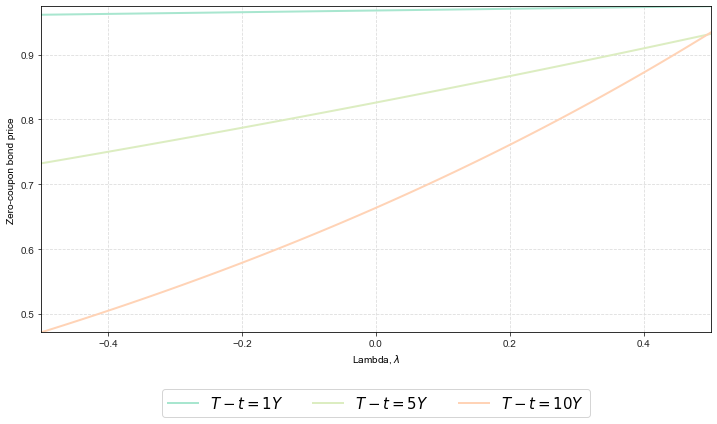

In [9]:
kappa = 0.3
beta = 0.03
theta = 0.05
r = 0.03
risk_premium_values = np.linspace(-0.5, 0.5, 100)

init_rates = [0.02, 0.04, 0.06, 0.08]

fig, ax = plt.subplots(figsize=(12, 6))

years = [1, 5, 10]
for y in years: 
    
    bond_prices = [calculate_zero_coupon_price(y, r, kappa, theta, beta, rp) for rp in risk_premium_values]
    
    ax.plot(risk_premium_values, bond_prices, label="$T-t = {}Y$".format(y))

ax.set_ylabel("Zero-coupon bond price")
ax.set_xlabel("Lambda, $\\lambda$")
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4, fontsize=15);

__Question 8__


In [10]:
theta = 0.05
kappa = 0.3
beta = 0.03
rp = -0.15

theta_hat = theta - (rp) * beta / kappa
vasicek_curve = VasicekCurve(short_rate=0.03, theta=theta_hat, kappa=kappa, beta=beta)

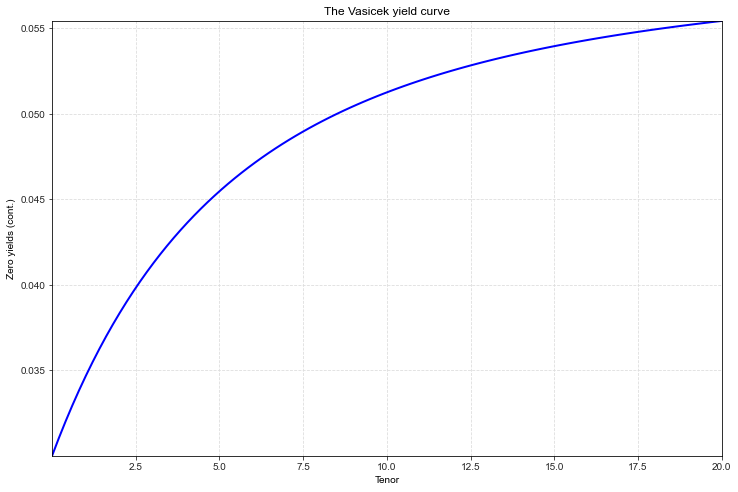

In [11]:
plot_tenors = np.linspace(0.0001, 20.0, 100)

fig, ax = plt.subplots(figsize=(12, 8))
plt.plot(plot_tenors, vasicek_curve.zero_rate_vector(plot_tenors), color="blue")
ax.set_xlabel('Tenor');
ax.set_ylabel('Zero yields (cont.)');
ax.set_title("The Vasicek yield curve");

## Problem 2: A dynamic Nelson-Siegel model

[Diebold and Li (2006)](https://www.sas.upenn.edu/~fdiebold/papers/paper49/Diebold-Li.pdf) consider a time-varying version of the Nelson-Siegel yield curve allowing for yield curve forecasting. 

The yield curve at time $t$ is specified as 

$$
y_t(\tau) = \beta_{1t} + \beta_{2t} \left( \frac{1 - e^{-\lambda_t \tau}}{\lambda_t \tau } \right) + \beta_{3t} \left( \frac{1 - e^{-\lambda_t \tau}}{\lambda_t \tau } - e^{-\lambda_t \tau}\right)
$$

The innovation is to interpret $\beta_{1t}, \beta_{2t}$ and $\beta_{3t}$ as three latent dynamic factors. The loading on $\beta_{1t}$ is 1 (long term factor). The loading on $\beta_{2t}$ is $ \frac{1 - e^{-\lambda_t \tau}}{\lambda_t \tau }$ which starts at 1 and montonically converges to zero (short term factor). The loading on $\beta_{3t}$ starts at zero, increases and then decays to zero (medium term factor). 

__Question 1__

[FRED](https://www.federalreserve.gov/data/nominal-yield-curve.htm) provides nominal yield curve data interpolated using the Nelson-Siegel-Svensson specificiation. These are not the data used by [Diebold and Li (2006)](https://www.sas.upenn.edu/~fdiebold/papers/paper49/Diebold-Li.pdf), but we will use it to show the princple of their method. 

Obtain the zero-coupon yields from the date where all tenors are available. 

__Question 2__

As we previously have seen, it would be possible to estimate the parameters $\theta_t = \{\beta_{1t}, \beta_{2t}, \beta_{3t}, \lambda_t\}$ each period by non-linear least squares. However, as we also have seen, we can replace the complicated numerical optimization problem with linear regression if we fix $\lambda_t$. [Diebold and Li (2006)](https://www.sas.upenn.edu/~fdiebold/papers/paper49/Diebold-Li.pdf) follow the same approach and fix $\lambda_t = 0.0609$ (they use tenor in months). This particular value of $\lambda_t$ ensures that the the medium term factor attains it maximum at the 30 month tenor. 

Find the value of $\lambda_t$ that maximize the loading of the curvature at the 30 month tenor.  

Estimate $\beta_{1t}, \beta_{2t}$ and $\beta_{3t}$ for each date when fixing $\lambda_t$ at the determined value. 

__Quesiton 3__

We want to plot the estimated "latent" factors against the ones observed in the market. 

* Plot the 10-year zero yield (level) in the same plot as $\beta_{1t}$
* Plot the 1-year minus the 10-year zero yield (slope)  in the same plot as $\beta_{2t}$
* Plot twice the 2-year yield minus the sum of the 1-year and 10-year yield in the same plot as $\beta_{3t}$

__Question 4__

We have so far just estimate Nelson-Siegel curves for each time period. To create a forecasting model for future yield curve, we need to specify a dynamic structure for the factors. 

[Diebold and Li (2006)](https://www.sas.upenn.edu/~fdiebold/papers/paper49/Diebold-Li.pdf) simply specify the dynamics as univariate AR(1) models: 

$$
\beta_{i,t+1} = a + b \beta_{i,t}, \; \; i = 1, 2, 3
$$

We estimate the AR(1) process for each factor on monthly data. This can be done by regressing $\beta_{i,t+1}$ on a constant and $\beta_{i,t}$. Estimate the models. 

__Note:__ It would also be possible to use e.g. a Vector AutoRegression (VAR) model  


__Question 5__

Simulate the latent factors for the next 10 years (consider 10,000 simulations). Plot the distribution of yield curves after 1 years. 



### Solution 

__Question 1__


In [12]:
all_zero_yields = get_nominal_yield_data(output_type='zero_yields')

In [13]:
all_zero_yields = all_zero_yields.dropna() /  100.0 

In [14]:
all_zero_yields.head(3)

,SVENY01,SVENY02,SVENY03,SVENY04,SVENY05,SVENY06,SVENY07,SVENY08,SVENY09,SVENY10,...,SVENY21,SVENY22,SVENY23,SVENY24,SVENY25,SVENY26,SVENY27,SVENY28,SVENY29,SVENY30
Date,,,,,,,,,,,,,,,,,,,,,
1985-11-25,0.078551,0.083626,0.087469,0.090408,0.092686,0.094481,0.095924,0.097110,0.098108,0.098969,...,0.104821,0.105196,0.105553,0.105893,0.106217,0.106526,0.106819,0.107099,0.107365,0.107618
1985-11-26,0.078527,0.083575,0.087420,0.090376,0.092677,0.094494,0.095956,0.097154,0.098158,0.099015,...,0.104497,0.104827,0.105139,0.105435,0.105715,0.105982,0.106234,0.106474,0.106701,0.106917
1985-11-27,0.078425,0.083522,0.087339,0.090231,0.092453,0.094193,0.095586,0.096727,0.097688,0.098515,...,0.104157,0.104514,0.104853,0.105176,0.105482,0.105773,0.106049,0.106311,0.106560,0.106796


__Question 2__

In [15]:
# define functions 
def calculate_slope(time_to_maturity: Union[float, np.ndarray], l: float): 
    
    return (1 - np.exp(-time_to_maturity * l)) / (time_to_maturity * l)

def calculate_curvature(time_to_maturity: Union[float, np.ndarray], l: float): 
    
    return (1 - np.exp(-time_to_maturity * l)) / (time_to_maturity * l) - np.exp(-(time_to_maturity * l ))


def ols_ns(observed_yields: np.ndarray, tenors: np.ndarray, l):   
    
    X = np.c_[np.ones_like(tenors),
              calculate_slope(tenors, l), 
              calculate_curvature(tenors, l)]

    est_params = np.linalg.lstsq(X, observed_yields, rcond=None)

    return est_params[0]

In [16]:
"""
Find value of lambda (l) to use
"""

obj_func = lambda x: -calculate_curvature(1.0 / 12.0 * 30.0, x)
optimize.minimize(obj_func, 0.1)

      fun: -0.29842560752563774
 hess_inv: array([[2.17782419]])
      jac: array([-3.35276127e-08])
  message: 'Optimization terminated successfully.'
     nfev: 16
      nit: 7
     njev: 8
   status: 0
  success: True
        x: array([0.71731277])

In [17]:
tenors = np.arange(1.0, 31.0, 1.0)
beta_estimates = all_zero_yields.apply(ols_ns, axis=1, args=(tenors, 0.71731277), result_type="expand")
beta_estimates.columns = ['beta1', 'beta2', 'beta3']

In [18]:
beta_estimates.head()

,beta1,beta2,beta3
Date,,,
1985-11-25,0.109195,-0.030280,-0.035927
1985-11-26,0.108698,-0.030797,-0.032908
1985-11-27,0.108348,-0.030080,-0.033569
1985-11-29,0.107994,-0.029916,-0.034312
1985-12-02,0.109150,-0.030848,-0.035485


__Qeustion 3__

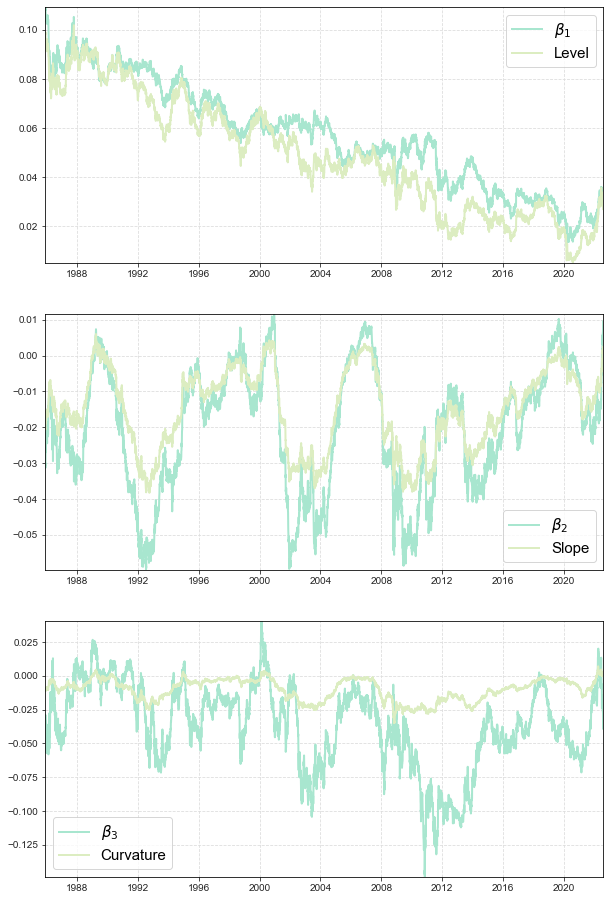

In [19]:
fig, ax = plt.subplots(3, 1, figsize=(10, 16))

"""
Level
"""

ax[0].plot(beta_estimates.index, beta_estimates.beta1, label="$\\beta_1$")
ax[0].plot(all_zero_yields.index, all_zero_yields['SVENY10'], label="Level");
ax[0].legend();

"""
Slope
"""

ax[1].plot(beta_estimates.index, beta_estimates.beta2, label="$\\beta_2$")
ax[1].plot(all_zero_yields.index, -all_zero_yields['SVENY10'] + all_zero_yields['SVENY01'], label="Slope");
ax[1].legend();


"""
Curvature
"""

ax[2].plot(beta_estimates.index, beta_estimates.beta3, label="$\\beta_3$")
ax[2].plot(all_zero_yields.index, 2 * all_zero_yields['SVENY02'] - 
           all_zero_yields['SVENY01'] - all_zero_yields['SVENY10'], label="Curvature");
ax[2].legend();


__Question 4__



In [20]:
"""
Resample Monthly Data
"""

beta_estimates_monthly = beta_estimates.resample("M").last()

periods = beta_estimates_monthly.shape[0]

"""
Estimate parameters using OLS
"""
# beta1
X = np.c_[np.ones(periods - 1),
          beta_estimates_monthly.values[:-1, 0]]

est_params_beta1 = np.linalg.lstsq(X, beta_estimates_monthly.values[1:, 0], rcond=None)

# beta2
X = np.c_[np.ones(periods - 1),
          beta_estimates_monthly.values[:-1, 1]]

est_params_beta2 = np.linalg.lstsq(X, beta_estimates_monthly.values[1:, 1], rcond=None)

# beta3
X = np.c_[np.ones(periods - 1),
          beta_estimates_monthly.values[:-1, 2]]

est_params_beta3 = np.linalg.lstsq(X, beta_estimates_monthly.values[1:, 2], rcond=None)

"""
Simulate AR
"""

def simulate_first_order_ar(initial_beta, a, b, sigma, horizon: float, dt: float =1.0/12.0, num_sim: int = 10000):
    
    """
    simulates short rate processes in a vasicek setting until a given horizon 
    
    Parameters
    ----------
    
    initial_short_rate:
        initial short rate
    kappa: 
        speed of mean reversion.
    theta: 
        long term mean of the short rate.
    dt:
        increments in time
    horizon:
        time until maturity/expiry (horizon).
    num_sim:
        number of simulations.
    """    
    
    num_periods = int(horizon / dt)
    betas = np.empty((num_sim, num_periods + 1))
    betas[:, 0] = initial_beta
    
    error_terms = np.random.normal(scale=sigma, size=(num_sim, num_periods))
    
    for i in range(1, num_periods + 1): 
        
        betas[:, i] = a + b * betas[:, i - 1] + error_terms[:, i - 1]
        
    return betas


__Question 5__

In [21]:
num_sim = 10000

beta1_sim = simulate_first_order_ar(beta_estimates_monthly.values[-1, 0],
                                   a=est_params_beta1[0][0],
                                   b=est_params_beta1[0][1], 
                                   sigma = np.sqrt(est_params_beta1[1] / (periods - 2)), 
                                   horizon=10.0,
                                   num_sim=num_sim)

beta2_sim = simulate_first_order_ar(beta_estimates_monthly.values[-1, 1],
                                   a=est_params_beta2[0][0],
                                   b=est_params_beta2[0][1], 
                                   sigma = np.sqrt(est_params_beta2[1] / (periods - 2)), 
                                   horizon=10.0,
                                   num_sim=num_sim)

beta3_sim = simulate_first_order_ar(beta_estimates_monthly.values[-1, 2],
                                   a=est_params_beta3[0][0],
                                   b=est_params_beta3[0][1], 
                                   sigma = np.sqrt(est_params_beta3[1] / (periods - 2)), 
                                   horizon=10.0,
                                   num_sim=num_sim)

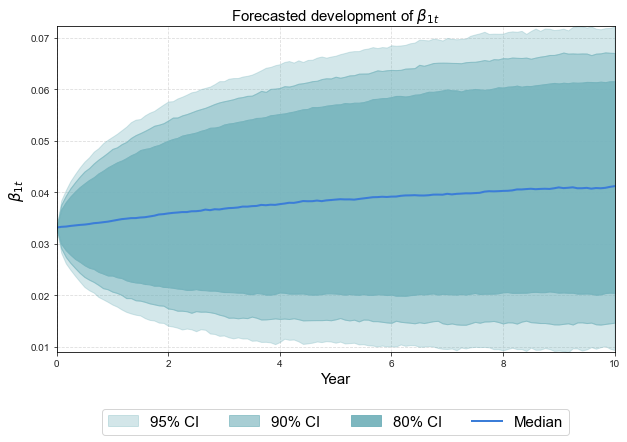

In [22]:
time_points = np.arange(0, 10.01, 1.0/12.0)

# calculate percentiles
percentiles = np.percentile(beta1_sim, [2.5, 5, 10, 50, 90, 95, 97.5], axis=0)

"""
Plot fan chart
"""

fig, ax = plt.subplots(figsize=(10, 6))

fan_chart(time_points,
          percentiles,
          color=default_colors['cyan'],
          color_median=default_colors['dark_blue'],
          labels=['95% CI', '90% CI', '80% CI', 'Median'],
          ax=ax)

ax.set_xlabel("Year", size=15)
ax.set_ylabel("$\\beta_{1t}$", size=15)
ax.set_title("Forecasted development of $\\beta_{1t}$", size=15)

ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=5, fontsize=15);

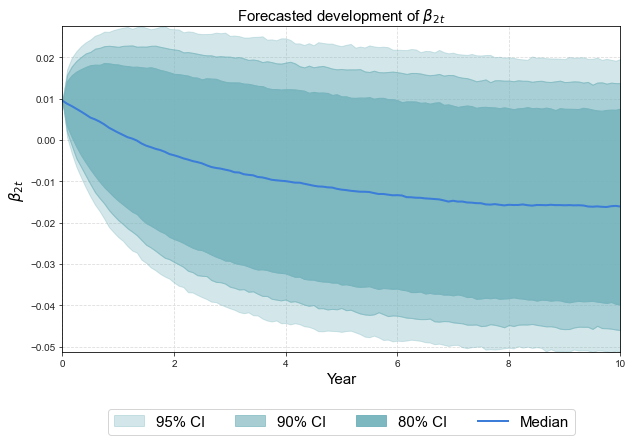

In [23]:
time_points = np.arange(0, 10.01, 1.0/12.0)

# calculate percentiles
percentiles = np.percentile(beta2_sim, [2.5, 5, 10, 50, 90, 95, 97.5], axis=0)

"""
Plot fan chart
"""

fig, ax = plt.subplots(figsize=(10, 6))

fan_chart(time_points,
          percentiles,
          color=default_colors['cyan'],
          color_median=default_colors['dark_blue'],
          labels=['95% CI', '90% CI', '80% CI', 'Median'],
          ax=ax)

ax.set_xlabel("Year", size=15)
ax.set_ylabel("$\\beta_{2t}$", size=15)
ax.set_title("Forecasted development of $\\beta_{2t}$", size=15)

ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=5, fontsize=15);

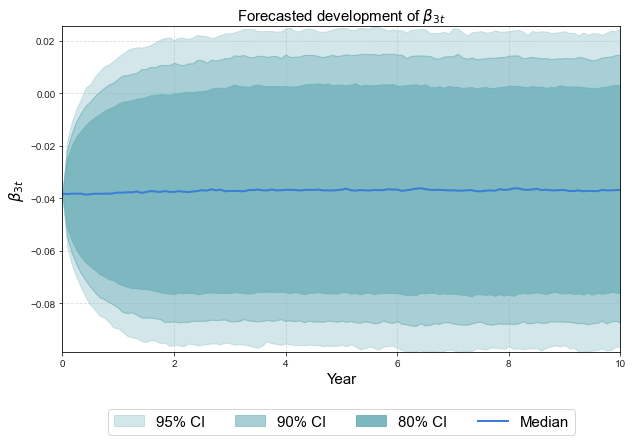

In [24]:
time_points = np.arange(0, 10.01, 1.0/12.0)

# calculate percentiles
percentiles = np.percentile(beta3_sim, [2.5, 5, 10, 50, 90, 95, 97.5], axis=0)

"""
Plot fan chart
"""

fig, ax = plt.subplots(figsize=(10, 6))

fan_chart(time_points,
          percentiles,
          color=default_colors['cyan'],
          color_median=default_colors['dark_blue'],
          labels=['95% CI', '90% CI', '80% CI', 'Median'],
          ax=ax)

ax.set_xlabel("Year", size=15)
ax.set_ylabel("$\\beta_{3t}$", size=15)
ax.set_title("Forecasted development of $\\beta_{3t}$", size=15)

ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=5, fontsize=15);

In [25]:
tenors_to_plot = np.linspace(1.0, 30.0, 100)
curves = np.empty((num_sim, 100))

period_to_select = 1 * 12  + 1

slope_loading = calculate_slope(tenors_to_plot, 0.71731277)
curvature_loading = calculate_curvature(tenors_to_plot, 0.71731277)

for i in range(num_sim):
    
    beta1 = beta1_sim[i, period_to_select]
    beta2 = beta2_sim[i, period_to_select]
    beta3 = beta3_sim[i, period_to_select]
    
    zero_yields = beta1 + beta2 * slope_loading + beta3 * curvature_loading    
    
    curves[i, :] = zero_yields

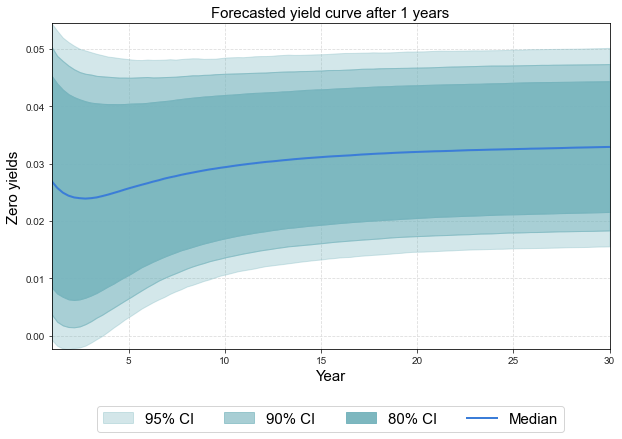

In [26]:
# calculate percentiles
percentiles = np.percentile(curves, [2.5, 5, 10, 50, 90, 95, 97.5], axis=0)

"""
Plot fan chart
"""

fig, ax = plt.subplots(figsize=(10, 6))

fan_chart(tenors_to_plot,
          percentiles,
          color=default_colors['cyan'],
          color_median=default_colors['dark_blue'],
          labels=['95% CI', '90% CI', '80% CI', 'Median'],
          ax=ax)

ax.set_xlabel("Year", size=15)
ax.set_ylabel("Zero yields", size=15)
ax.set_title("Forecasted yield curve after 1 years", size=15)

ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=5, fontsize=15);

## Problem 3: Principle component analysis of yield data

__Note:__ This problem is somewhat inspired by chapter 6 and 7 in
[Riccardo Rebonato (2018), "Bond Pricing and Yield-Curve Modelling - A Structural Approach"](https://www.amazon.com/Bond-Pricing-Yield-Curve-Modeling/dp/1107165857)

After this problem it should be clear that we may model yields and yields changes with a limited number of factors. 

__Question 1__

Get nominal yield data and consider only observations where all data is available. Demean the yields and yield changes and calculate the covariance and correlation matrix. 

Plot a heatmap of the correlation matrix for the yields and yield changes. 

__Question 2__

The above analysis will indicate that the different parts of the yield curve are highly correlated, e.g. the yields representing the short end of the yield curve are highly correlated but less so with the long end. 

Find the eigenvectors and eigenvalues of the covariance matrix for the yields and yield changes. 

__Question 3__

According to [wikipedia](https://en.wikipedia.org/wiki/Principal_component_analysis) principle component analysis is defined as an orthogonal linear transformation that transforms the data to a new coordinate system such that the greatest variance by some scalar projection of the data comes to lie on the first coordinate (called the first principal component), the second greatest variance on the second coordinate, and so on. 

If we let $\mathbf{X}$ ($n \times p$ where $n$ is the number of observations and $p$ is the number of variables) denote the demeaned data matrix, then we can find the principle components using 

$$
\mathbf{T} =  \mathbf{X} \mathbf{V}
$$

where $\mathbf{V}$ is a $p \times p$ matrix where the columns are the eigenvectors of the covariance matrix (simply $\mathbf{X}^\top \mathbf{X}$ since we have demeand the columns). 

Find the principle components and plot the three first over time. 

__Question 4__

The eigenvalues, $\lambda_i, \; i=1,..., p$,  are equal to the variance of the principle components. The proportion of the variance explained by the $i$'th principle component can be written as 

$$
\frac{\lambda_i}{\sum_{j=1}^p \lambda_j}
$$

Find the proportion of the variance explained for the different PCAs.

__Question 5__

It follows directly that 

$$
\mathbf{T} \mathbf{V}^\top = \mathbf{X}
$$

we can think of $\mathbf{V}^\top $ as a matrix of factor loadings. Plot the factor loadings for the first three principle components. 

### Solution 

__Question 1__

In [27]:
all_zero_yields = get_nominal_yield_data(output_type='zero_yields')
#all_zero_yields = all_zero_yields.resample("M").last()
all_zero_yields = all_zero_yields.dropna() /  100.0 
all_zero_yields.head()

yield_changes = (all_zero_yields - all_zero_yields.shift(1)).dropna()
yield_changes.head()

,SVENY01,SVENY02,SVENY03,SVENY04,SVENY05,SVENY06,SVENY07,SVENY08,SVENY09,SVENY10,...,SVENY21,SVENY22,SVENY23,SVENY24,SVENY25,SVENY26,SVENY27,SVENY28,SVENY29,SVENY30
Date,,,,,,,,,,,,,,,,,,,,,
1985-11-26,-0.000024,-0.000051,-0.000049,-0.000032,-0.000009,0.000013,0.000032,0.000044,0.000050,0.000046,...,-0.000324,-0.000369,-0.000414,-0.000458,-0.000502,-0.000544,-0.000585,-0.000625,-0.000664,-0.000701
1985-11-27,-0.000102,-0.000053,-0.000081,-0.000145,-0.000224,-0.000301,-0.000370,-0.000427,-0.000470,-0.000500,...,-0.000340,-0.000313,-0.000286,-0.000259,-0.000233,-0.000209,-0.000185,-0.000163,-0.000141,-0.000121
1985-11-29,-0.000511,-0.000374,-0.000348,-0.000379,-0.000429,-0.000481,-0.000525,-0.000555,-0.000573,-0.000577,...,-0.000359,-0.000342,-0.000327,-0.000315,-0.000303,-0.000294,-0.000286,-0.000279,-0.000273,-0.000268
1985-12-02,0.000262,0.000309,0.000368,0.000442,0.000526,0.000615,0.000705,0.000790,0.000868,0.000936,...,0.001058,0.001034,0.001008,0.000981,0.000952,0.000923,0.000894,0.000865,0.000836,0.000807
1985-12-03,0.000351,0.000222,0.000181,0.000182,0.000196,0.000208,0.000208,0.000194,0.000165,0.000122,...,-0.000729,-0.000804,-0.000876,-0.000945,-0.001010,-0.001072,-0.001131,-0.001187,-0.001241,-0.001291


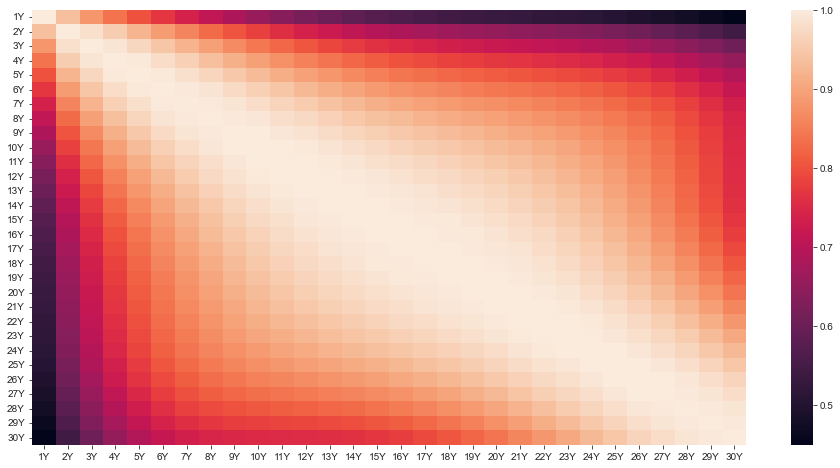

In [28]:
yield_names = ['{}Y'.format(i) for i in range(1, 31, 1)]

"""
Find covariance matrix
"""

yield_matrix = all_zero_yields.values
yield_matrix_demean = yield_matrix - yield_matrix.mean(axis=0)
yield_cov_mat = np.cov(yield_matrix_demean, rowvar=False)
yield_corr_mat = np.corrcoef(yield_matrix_demean, rowvar=False)

yield_change_matrix = yield_changes.values
yield_change_matrix_demean = yield_change_matrix - yield_change_matrix.mean(axis=0)
yield_change_cov_mat = np.cov(yield_change_matrix_demean, rowvar=False)
yield_change_corr_mat = np.corrcoef(yield_change_matrix_demean, rowvar=False)

"""
Plot the correlation matrix
"""
fig, ax = plt.subplots(figsize=(16, 8))
sns.heatmap(yield_change_corr_mat, xticklabels=yield_names, yticklabels=yield_names);

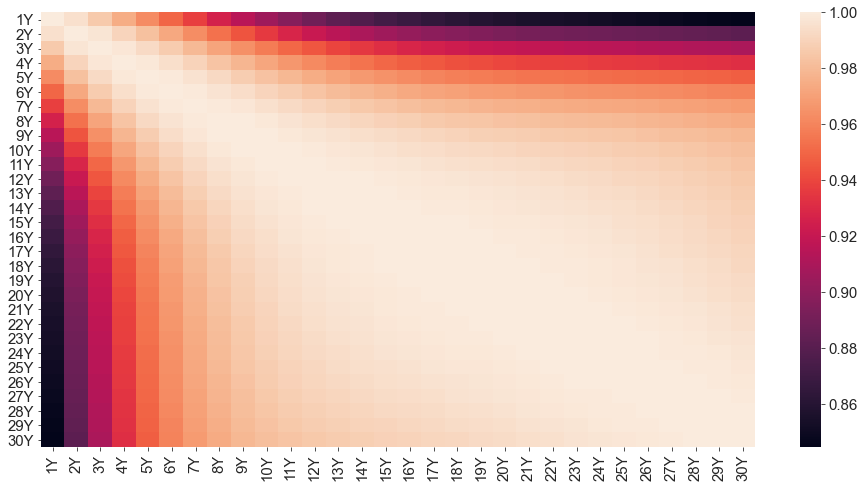

In [101]:
fig, ax = plt.subplots(figsize=(16, 8))
sns.heatmap(yield_corr_mat, xticklabels=yield_names, yticklabels=yield_names);


__Question 2__

In [102]:
eigvals_level, eigvectors_level = np.linalg.eig(yield_cov_mat)
eigvals_change, eigvectors_change = np.linalg.eig(yield_change_cov_mat)

In [103]:
#eigvectors_level = -eigvectors_level
#eigvectors_change = -eigvectors_change

__Question 3__

In [104]:
pca_level = yield_matrix_demean @ eigvectors_level
pca_change = yield_change_matrix_demean @ eigvectors_change

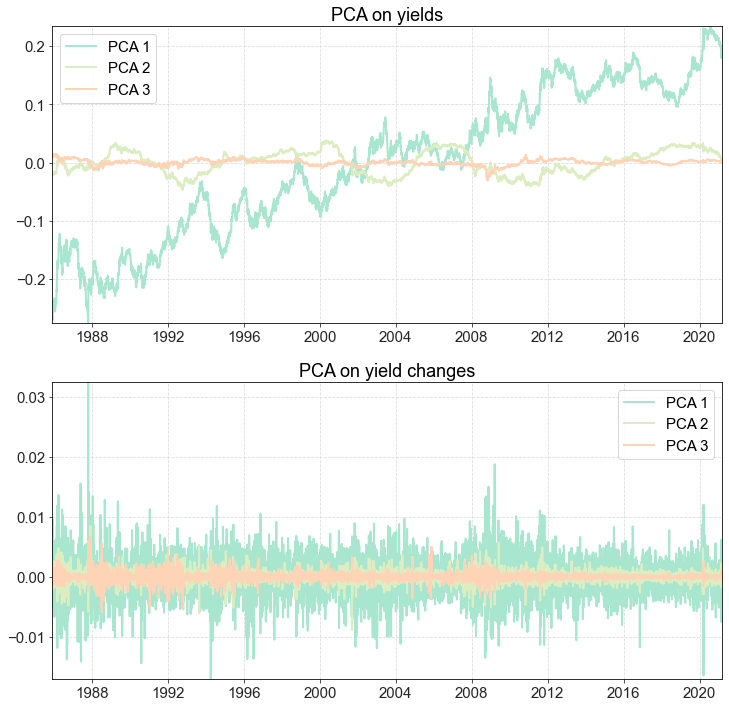

In [105]:
fig, ax = plt.subplots(2, figsize=(12, 12))

ax[0].plot(all_zero_yields.index, pca_level[:, 0], label="PCA 1")
ax[0].plot(all_zero_yields.index, pca_level[:, 1], label="PCA 2")
ax[0].plot(all_zero_yields.index, pca_level[:, 2], label="PCA 3")
ax[0].legend();
ax[0].set_title("PCA on yields")

ax[1].plot(yield_changes.index, pca_change[:, 0], label="PCA 1")
ax[1].plot(yield_changes.index, pca_change[:, 1], label="PCA 2")
ax[1].plot(yield_changes.index, pca_change[:, 2], label="PCA 3")
ax[1].legend();
ax[1].set_title("PCA on yield changes");

__Question 4__

In [106]:
explained_level = eigvals_level / np.sum(eigvals_level)
explained_change = eigvals_change / np.sum(eigvals_change)

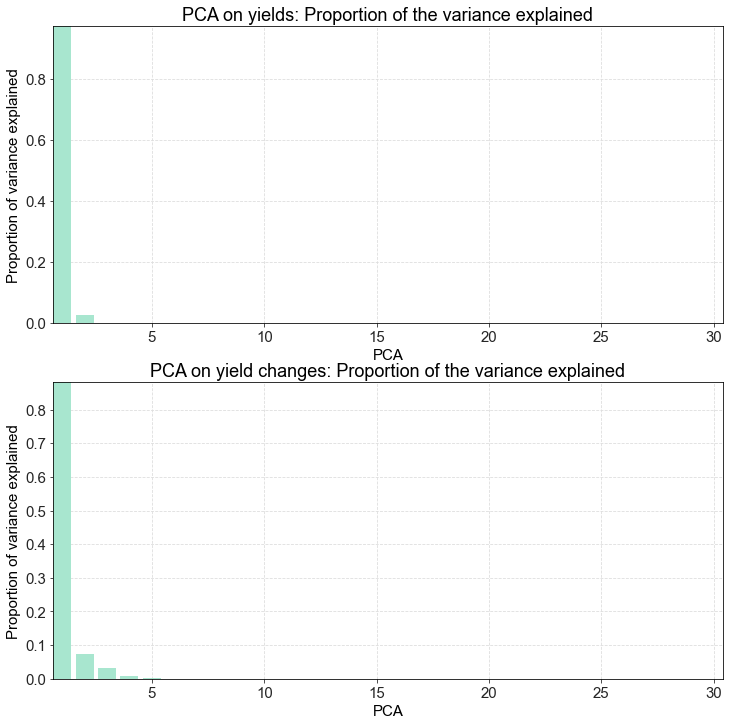

In [107]:
fig, ax = plt.subplots(2, figsize=(12, 12))

ax[0].bar(np.arange(1.0, 31.0, 1.0), explained_level)
ax[0].set_title("PCA on yields: Proportion of the variance explained")
ax[0].set_xlabel("PCA")
ax[0].set_ylabel("Proportion of variance explained")

ax[1].bar(np.arange(1.0, 31.0, 1.0), explained_change)
ax[1].set_title("PCA on yield changes: Proportion of the variance explained");
ax[1].set_xlabel("PCA")
ax[1].set_ylabel("Proportion of variance explained");

__Question 5__

In [108]:
factor_loading_level = eigvectors_level
factor_loading_change = eigvectors_change

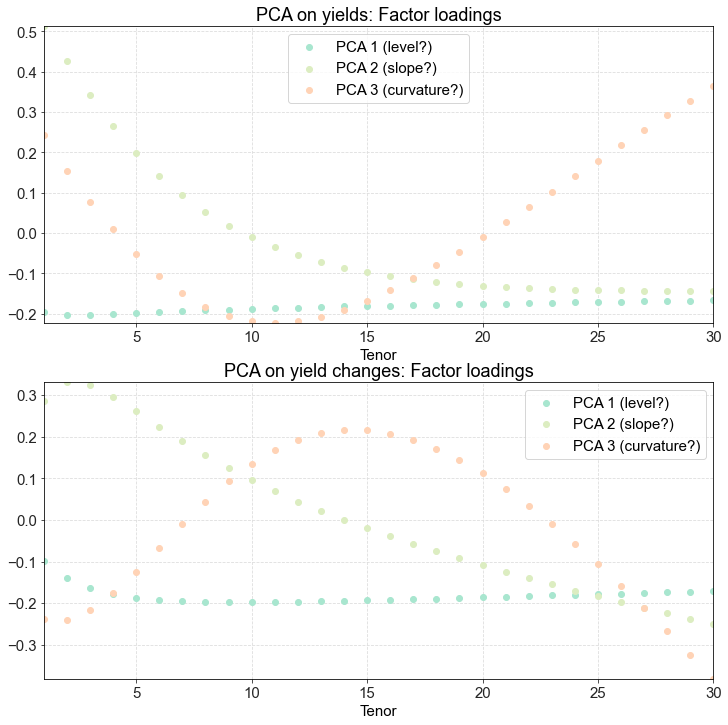

In [109]:
fig, ax = plt.subplots(2, figsize=(12, 12))

ax[0].scatter(np.arange(1.0, 31.0, 1.0), factor_loading_level[:, 0], label = "PCA 1 (level?)")
ax[0].scatter(np.arange(1.0, 31.0, 1.0), factor_loading_level[:, 1], label = "PCA 2 (slope?)")
ax[0].scatter(np.arange(1.0, 31.0, 1.0), factor_loading_level[:, 2], label = "PCA 3 (curvature?)")
ax[0].legend()
ax[0].set_title("PCA on yields: Factor loadings")
ax[0].set_xlabel("Tenor")
#ax[0].set_ylabel("Proportion of variance explained")

ax[1].scatter(np.arange(1.0, 31.0, 1.0), factor_loading_change[:, 0], label = "PCA 1 (level?)")
ax[1].scatter(np.arange(1.0, 31.0, 1.0), factor_loading_change[:, 1], label = "PCA 2 (slope?)")
ax[1].scatter(np.arange(1.0, 31.0, 1.0), factor_loading_change[:, 2], label = "PCA 3 (curvature?)")
ax[1].legend()
ax[1].set_xlabel("Tenor")
ax[1].set_title("PCA on yield changes: Factor loadings");

# References


## Articles

[Vasicek (1977), An equilibrium characterization of the term structure](https://www.sciencedirect.com/science/article/abs/pii/0304405X77900162?via%3Dihub)

[Diebold and Li (2006), Forecasting the term structure of government bond yields](https://www.sas.upenn.edu/~fdiebold/papers/paper49/Diebold-Li.pdf)

## Books

[Claus Munk (2013), "Fixed income modelling"](https://www.amazon.co.uk/Fixed-Income-Modelling-Claus-Munk/dp/0198716443)

[Riccardo Rebonato (2018), "Bond Pricing and Yield-Curve Modelling - A Structural Approach"](https://www.amazon.com/Bond-Pricing-Yield-Curve-Modeling/dp/1107165857)